In [1]:
# Import necessary libraries and packages
import pandas as pd
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot
import warnings
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from math import exp
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Preferred settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)


In [2]:
#Import CO2 emissions data - OWID
data = pd.read_csv('../Data/carbon-emissions/owid-co2-data.csv')

#Observe data shape and head
print(data.shape)

(25204, 58)


In [3]:
data.describe()

,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
count,25204.000000,23949.000000,3976.000000,24931.000000,23585.000000,3976.000000,23307.000000,3976.000000,23949.000000,2.394900e+04,23949.000000,15389.000000,3761.000000,9141.000000,17188.000000,12248.000000,4382.000000,8845.000000,20539.000000,1999.000000,12218.000000,16860.000000,4381.000000,8835.000000,20181.000000,1999.000000,3976.000000,12248.000000,17188.00000,4382.000000,8845.000000,20539.000000,1999.000000,12248.000000,17188.000000,4382.000000,8845.000000,20539.000000,1999.000000,12248.000000,17188.000000,4382.000000,8845.000000,20539.000000,1999.000000,5208.000000,5155.000000,5211.000000,5157.000000,5211.000000,5157.000000,2.287800e+04,1.353800e+04,8690.000000,8681.000000,6803.000000
mean,1953.225797,267.861942,916.755170,21.098600,5.146889,-2.415624,4.170811,6.567721,4.983979,1.035710e+04,5.126531,0.421795,0.370038,0.238931,175.358171,12.888607,15.000326,108.750774,106.254381,15.753891,0.113037,1.551520,0.875319,1.413336,2.635498,0.080168,22.961190,4.419452,6.98983,5.861506,5.405564,2.993497,14.295183,307.761167,8791.767180,425.698588,2587.096729,3296.584230,293.588436,4.462228,7.211834,5.621670,5.242400,3.001620,13.403622,441.481429,8.099506,82.253370,2.046923,29.308135,0.606690,7.072322e+07,2.877088e+11,1569.083895,25568.487454,1.850291
std,53.791369,1521.680894,3373.348275,702.565991,55.259760,182.444942,14.912201,6.927957,17.704994,6.120603e+04,18.480079,0.483864,0.265374,0.233550,786.106838,77.258563,40.471977,441.064563,602.683622,39.385589,0.148907,2.552112,5.477923,3.654290,15.129275,0.055779,45.055039,15.950613,20.76197,14.874259,18.408881,12.018682,28.570911,1706.159528,39131.720328,1320.911296,12347.690600,21645.263301,777.706862,15.685264,21.636504,15.021334,18.926934,12.134102,27.019447,3089.039496,9.387477,566.702756,3.534126,199.291118,0.844671,3.795858e+08,2.180094e+12,9066.102799,33319.956208,1.575161
min,1750.000000,0.000000,0.197000,-99.640000,-1895.244000,-1657.998000,0.000000,0.055000,0.000000,0.000000e+00,0.000000,0.000000,0.006000,0.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-96.760000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-85.620000,-50.487000,0.000000,0.000000,0.000000,0.000000,1.490000e+03,5.543200e+07,0.000000,0.000000,0.050000
25%,1925.000000,0.528000,10.319750,-0.450000,-0.011000,-0.892500,0.253000,1.240250,0.010000,6.992000e+00,0.000000,0.140000,0.216000,0.178000,0.322000,0.129000,0.253250,0.385000,0.311000,0.747500,0.020000,0.054000,0.021000,0.031000,0.121000,0.036000,-1.757500,0.050000,0.01000,0.090000,0.030000,0.010000,0.300000,1.613000,5.516250,4.071250,3.239000,3.921000,7.709000,0.040000,0.000000,0.060000,0.010000,0.010000,0.190000,8.162500,2.514000,2.150000,0.715000,0.535000,0.228000,1.291899e+06,9.828867e+09,6.997000,3270.369000,0.856000
50%,1967.00

# Data Cleaning and Preprocessing

We focused on post-1950 data for our comparative analysis and global EDA since some countries are missing significant data before that time. Major carbon emitting countries' emission activites intensified post 1950 period, especially India. For our modelling process, however, focusing on India, the data form 1878 is continous, so we include all data for India from 1900. First, We'll be predicting the CO2 emissions for India

In [4]:
#load data
df_India = data

#only include India co2 per capita data post-1900
df_India = df_India[df_India['year'] >= 1900]
df_India = df_India[df_India['country'] == 'India']
df_India = df_India[['year', 'co2_per_capita']]

#observe shape of reformatted df
print(df_India.shape)

(121, 2)


In [5]:
#Convert year to index
df_India.set_index('year', inplace=True)

#Convert year to DateTime object
df_India.index = pd.to_datetime(df_India.index, format='%Y')

In [6]:
#observe updated df
#df_India.head()
df_India.sample(5)

,co2_per_capita
year,
1966-01-01,0.313
1980-01-01,0.418
1967-01-01,0.307
1959-01-01,0.230
1920-01-01,0.110


# Exploratory Data Analysis

Before starting to analyse the stationarity of data, lets need to understand the trend, seasonality and bias of our data. 

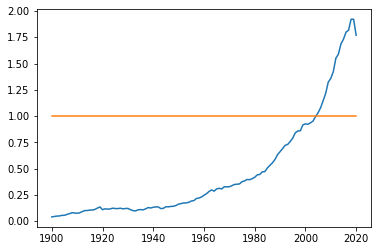

In [7]:
#observe trend and seasonality
decom = seasonal_decompose(df_India['co2_per_capita'], model='multiplicative')
plt.plot(decom.trend)
plt.plot(decom.seasonal)


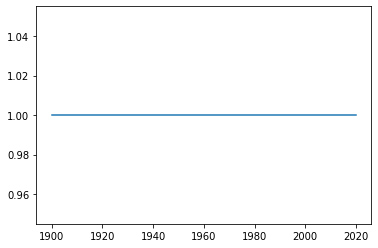

In [8]:
#observe residue
plt.plot(decom.resid)

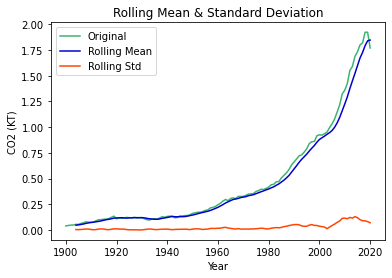

In [9]:
#Visualize India's CO2 emissions since 1900,
#including 5-year rolling mean and rolling standard deviation

roll_mean = df_India.rolling(window=5, center=False).mean()
roll_std = df_India.rolling(window=5, center=False).std()

plt.plot(df_India, color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('CO2 (KT)')
plt.show(block=False)

Working with time series data we need to understand the nature of data, that is the trends and stationarity.

Stationarity can be checked by performing an **Augmented Dickey-Fuller (ADF) test** 

null hypothesis - there is a unit root in an AR model, which implies that the data series is not stationary

> - p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
> - p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary

#### Dickey-Fuller Test

In [10]:
#perform Dickey-Fuller test
test_result = adfuller(df_India['co2_per_capita'][1:-1])
df_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_result

ADF Statistic                                                        4.772611
p-value                                                                   1.0
#Lags Used                                                                 12
No. of Observations Used                                                  106
Critical Values             {'1%': -3.4936021509366793, '5%': -2.889217423...
dtype: object

With p-value of 1.0 ( >0.05), we cannot reject that null hypothesis that this is non-stationary.

we also can see that our ADF statistic value (6.76) is greater than tha value -3.49 at 1%. This suggests that we cannot reject the null hypothesis with a significance of less than 1%, i.e. a low probability that the result is a statistical fluke. The process has unit root and in turn the timer series is un-stationary or does have time-dependent structure

As we observe the data is non-stationary, this cannot be fit for autocorrelation analysis as ACF and PACF assumes data stationary. Lets remedy this below before fitting our model.
    

## Addressing Trends and Stationarity

### Log Transformation

In log transformation we apply logarithmic function to a point, and model the time series with the new log-transformed data. 

we can address lack of variance and covariance by log transformation

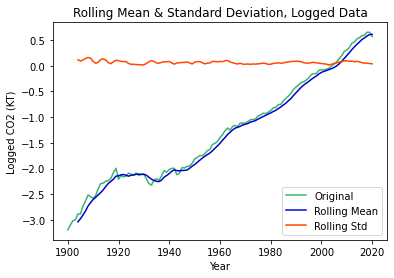

In [11]:
#apply log transformation
#Create new dataframe that contains the logged values of the original one
log_India = log(df_India)

#Visualize Logged data, including 5-year rolling mean and standard deviation
roll_mean_log = log_India.rolling(window=5, center=False).mean()
roll_std_log = log_India.rolling(window=5, center=False).std()

plt.plot(log_India, color='mediumseagreen', label='Original')
plt.plot(roll_mean_log, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std_log, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation, Logged Data')
plt.xlabel('Year')
plt.ylabel('Logged CO2 (KT)')
plt.show(block=False)

Lets again check the p-value by doing a ADF test

**Dickey-Fuller test for log transformed data**

In [12]:
#perform Dickey-Fuller test for log tranformed data
test_result = adfuller(log_India['co2_per_capita'][1:-1])
df_log_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_log_result

ADF Statistic                                                        1.182281
p-value                                                              0.995861
#Lags Used                                                                 11
No. of Observations Used                                                  107
Critical Values             {'1%': -3.492995948509562, '5%': -2.8889546480...
dtype: object

With p-value of 0.99 ( >0.05), we still cannot reject that null hypothesis that this data is non-stationary. 

Log transformation did not help achieve stationarity. So lets try another way to achieve true stationarity by subtracting rolling mean of log tranformation



#### Subtracting the Rolling Mean of the Log Transformation

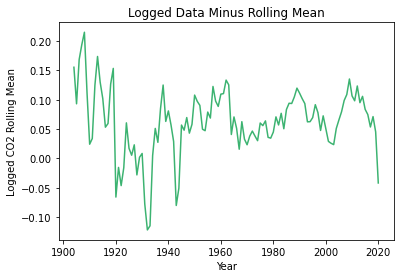

In [13]:
#subtracting rolling mean of log transformation
log_minus_rollmean = log_India - roll_mean_log

#drop null values
log_minus_rollmean.dropna(axis=0, inplace=True)

#observe data
plt.plot(log_minus_rollmean, color='mediumseagreen')
plt.title('Logged Data Minus Rolling Mean')
plt.xlabel('Year')
plt.ylabel('Logged CO2 Rolling Mean')
plt.show(block=False)


Lets again check the p-value by doing a ADF test

**Dickey-Fuller test for log-minus-roll-mean data**

In [14]:
#perform Dickey-Fuller test for log-minus-rollmean data
test_result = adfuller(log_minus_rollmean['co2_per_capita'][1:-1])
df_sublog_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_sublog_result

ADF Statistic                                                       -3.855635
p-value                                                              0.002387
#Lags Used                                                                 13
No. of Observations Used                                                  101
Critical Values             {'1%': -3.4968181663902103, '5%': -2.890610751...
dtype: object

With p-value of 0.002 ( <0.05), we reject that null hypothesis. This data does not unit root and is stationary.

we also can see that our ADF statistic value (-3.85) is less than the value -3.49 at 1%. This suggests that we can reject the null hypothesis with a significance of less than 1%.

This data looks much more stationary based on its plot and its Dickey-Fuller test alos yielded similar observation as observed above with a very low p-value, indicating that we can confidently reject the null hypothesis that the data is non-stationary.



> Even though this data is stationary and would likely work well in a time series model, the results of this model would not be interpretable in the context of our business problem.  

> For our predictions to be useful, we need them to be in terms of CO2 emissions in K Tonnes. Altering our data to this degree would make them uninterpretable for this purpose, and so we will not pursue a model on this data

### Differencing

differencing is a very powerful technique to address non-stationary time-series data. Differencing works very well with practical time series.

The original data where the ADF test arrived at p-value = 1 suggests no difference between the groupds other than due to chance


Now that we have observed log tranformed, we will now observe differnece of our original data until we achieve stationarity so we can model on both datasets

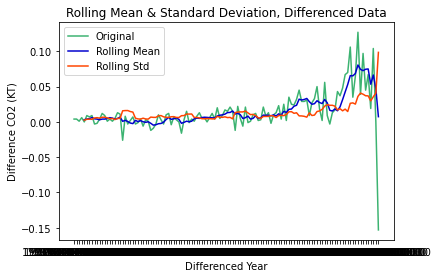

In [15]:
#create dataframe for differencing
diff = df_India.diff().dropna().rename(index=str, columns={"co2_per_capita":"Differenced Observations"})

#Visualize differenced data, inclusing 5-year rolling mean and standard deviation
roll_mean_diff = diff.rolling(window=5, center=False).mean()
roll_std_diff = diff.rolling(window=5, center=False).std()

plt.plot(diff, color='mediumseagreen', label='Original')
plt.plot(roll_mean_diff, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std_diff, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation, Differenced Data')
plt.xlabel('Differenced Year')
plt.ylabel('Difference CO2 (KT)')
plt.show(block=False)


Lets again check the p-value by doing a ADF test

**Dickey-Fuller test for log-minus-roll-mean data**

In [16]:
#perform Dickey-Fuller test for log-minus-rollmean data
diff_result = adfuller(diff['Differenced Observations'][1:-1])
df_diff_result = pd.Series(diff_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_diff_result

ADF Statistic                                                        -1.11171
p-value                                                               0.71038
#Lags Used                                                                  3
No. of Observations Used                                                  114
Critical Values             {'1%': -3.489057523907491, '5%': -2.8872463271...
dtype: object

Applying 1st order differencing to the original data (p-value = 1), we observe p-value obtained performing ADF test on differenced data is 0.714 (>0.05). we cannot reject the null hypothesis.

we also can see that our ADF statistic value (-1.10) is greater than the value -3.48 at 1%. This suggests that we cannot reject the null hypothesis with a significance of less than 1%.

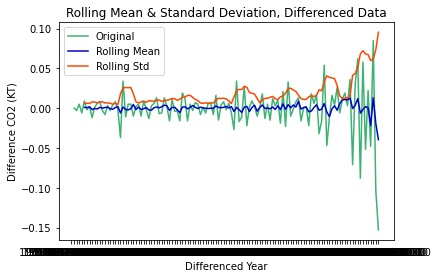

In [17]:
diff2 = diff.diff().rename(index=str, columns={"Differenced Observations":"2nd"})

#Visualize differenced data, inclusing 5-year rolling mean and standard deviation
roll_mean_diff = diff2.rolling(window=5, center=False).mean()
roll_std_diff = diff2.rolling(window=5, center=False).std()

plt.plot(diff2, color='mediumseagreen', label='Original')
plt.plot(roll_mean_diff, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std_diff, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation, Differenced Data')
plt.xlabel('Differenced Year')
plt.ylabel('Difference CO2 (KT)')
plt.show(block=False)


In [18]:
#perform Dickey-Fuller test for log-minus-rollmean data
diff2_result = adfuller(diff2['2nd'][1:-1])
df_diff2_result = pd.Series(diff2_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_diff2_result

ADF Statistic                                                      -10.832628
p-value                                                                   0.0
#Lags Used                                                                  2
No. of Observations Used                                                  115
Critical Values             {'1%': -3.4885349695076844, '5%': -2.887019521...
dtype: object

Statistically p-value can never be absolute zero as it means event we are already observing doesn't exist.

While addressing stationarity of time series data, this observation can reject the null hypothesis (real p-value observed is in the order of 1.69e-19). 
The ADF statistic value (-10.80) is very much less than the value -3.48 at 1%. This suggests that we can comfortably reject the null hypothesis with a significance of less than 1%.

Based on real p-value of 1.69e-19, twnding to zero, we have achieved stationarity by 2nd order differencing. We will keep this in count as we test d values in our ARIMA models


## Modelling


We will create time series models on both our logged data and original data to see which yields better results.

### Logged Data

**ACF for Logged Data**

ACF gives correlation between time series with a lagged version of itself. The autocorrelation function starts a lag 0, which is correlation of the time series with itself and therefore results in correlation of 1.

Auto correlation graphs are used to determine the order of MA model (p values) to be used in the ARIMA Model

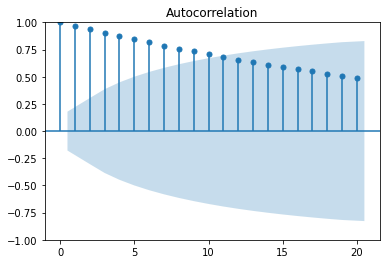

In [19]:
# observe ACF for logged data
plot_acf(log_India[:-1], alpha=.05, lags=20);

**PACF for Logged Data**

PACF gives additional correaltion explained by each successive lagged term. A partial autocorrelation at lag k is the autocorrelation between 𝑋𝑡  and 𝑋𝑡−𝑘. 

Partial Autocorrelation are used to determine the order of AR model - q values to be used in the ARIMA Model

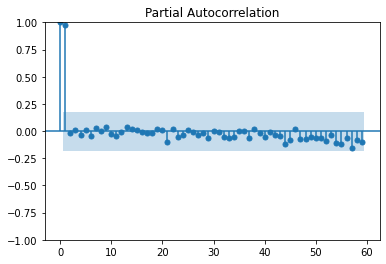

In [20]:
# PACF for logged data
plot_pacf(log_India[:-1], alpha=.05, lags=59);

From the above ACF and PACF for our logged data, we can observe

> - A series that has a dampened geometric decay of Autocorrelation and Significant at each lag  𝑝  / Cuts off after lag  𝑝 - AR  𝑝   model

> -  Our data displayes an AR signature since ACF diminishes gradually and the PACF uctts off sharply at lag 2, showing string correlation. This tells us we would expect to have atleast one AR parameter.

> -  When instantiating an ARIMA model, we expect a relatively large number of MA terms due to large number of significant ACF points and relatively smaller AR terms due to small number of significant PACF points.

**ARIMA Model for Logged Data**

we triend many differenct p,d, and q parameters for an ARIMA model on our logged data. The below parameters yielded best results

In [21]:
#Instantiate model
model_log = ARIMA(log_India[:-1], order=(2,0,2))

#Fit Model
results = model_log.fit()

#observe summary statistics
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:         co2_per_capita   No. Observations:                  120
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 170.324
Date:                Wed, 23 Mar 2022   AIC                           -328.647
Time:                        18:41:41   BIC                           -311.922
Sample:                    01-01-1900   HQIC                          -321.855
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2083      2.118     -0.570      0.568      -5.360       2.944
ar.L1          0.0332      0.098      0.340      0.734      -0.159       0.225
ar.L2          0.9653      0.100      9.695      0.0

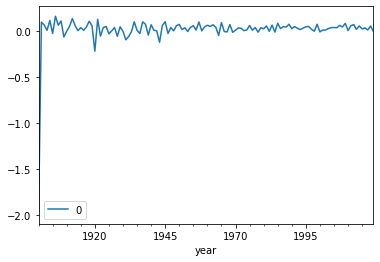

In [22]:
#observe residuals/errors
residuals = DataFrame(results.resid)
residuals.plot()
plt.show()


In [23]:
#observe distributions
residuals.describe()

,0
count,120.000000
mean,0.008962
std,0.190513
min,-1.985854
25%,-0.001710
50%,0.031765
75%,0.054662
max,0.156651


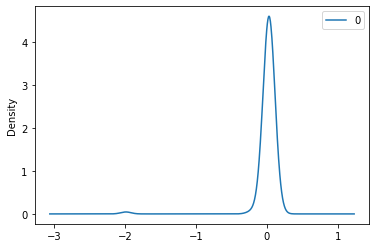

In [24]:
#observe linearity
residuals.plot(kind='kde')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

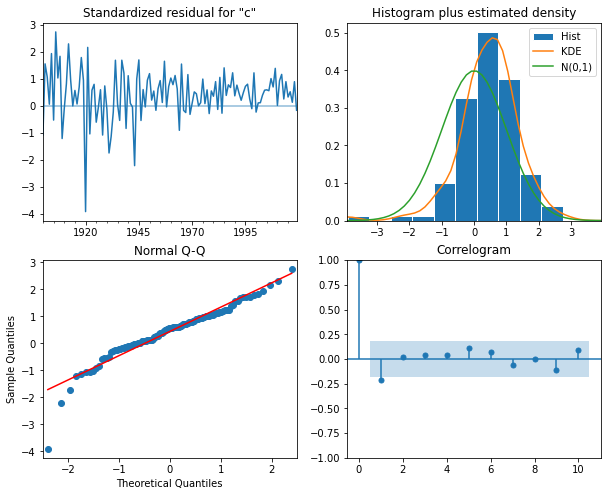

In [25]:
#observe diagnostics
results.plot_diagnostics(figsize=(10,8))
plt.show

### Original Data

We will now observe an ARIMA model on our original, non-logged data. We saw this data needs to be differenced in order to achieve stationarity, so we expect to have a d value of at least 1 for out best model

**ACF and PACF for Original Data**

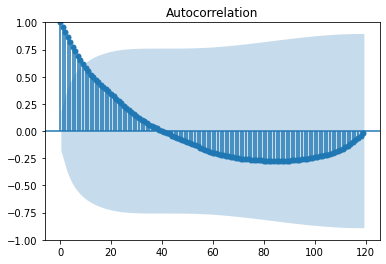

In [26]:
# ACF for original data
plot_acf(df_India[:-1], alpha=.05, lags=119);

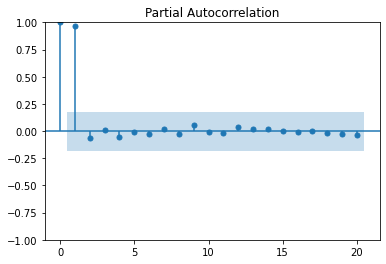

In [27]:
# PACF for original data
plot_pacf(df_India[:-1], alpha=.05, lags=20);

From the above ACF and PACF for our original data, we can observe

> - A series that has a dampened geometric decay of Autocorrelation and Significant at each lag  𝑝  / Cuts off after lag  𝑝 - AR  𝑝   model

> - Our data displayes an AR signature since ACF diminishes gradually and the PACF uctts off sharply at lag 2, showing string correlation. This tells us we would expect to have atleast one AR parameter.

> -  When instantiating an ARIMA model, we expect a relatively large number of MA terms due to large number of significant ACF points and relatively smaller AR terms due to small number of significant PACF points. 

**ARIMA Model for Original Data**

we tried many different p,d, and q parameters for an ARIMA model on our original data. The set of parameters yielded the best resutls, which we will comapre in mode details later.

In [28]:
# Instantiate model
mod212 = ARIMA(df_India[:-1], order=(2,1,2))

# Fit model
mod212_fit = mod212.fit()

# Observe summary statistics
print(mod212_fit.summary())


                               SARIMAX Results                                
Dep. Variable:         co2_per_capita   No. Observations:                  120
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 321.558
Date:                Wed, 23 Mar 2022   AIC                           -633.116
Time:                        18:41:43   BIC                           -619.220
Sample:                    01-01-1900   HQIC                          -627.473
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0298      0.144      7.149      0.000       0.747       1.312
ar.L2         -0.0602      0.149     -0.405      0.686      -0.352       0.231
ma.L1         -1.0752      0.119     -9.009      0.0

In [29]:
# Instantiate model
mod222 = ARIMA(df_India[:-1], order=(2,1,3))

# Fit model
mod222_fit = mod222.fit()

# Observe summary statistics
print(mod222_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         co2_per_capita   No. Observations:                  120
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 321.772
Date:                Wed, 23 Mar 2022   AIC                           -631.544
Time:                        18:41:43   BIC                           -614.870
Sample:                    01-01-1900   HQIC                          -624.773
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1164      0.907      0.128      0.898      -1.662       1.895
ar.L2          0.8137      0.871      0.935      0.350      -0.893       2.520
ma.L1         -0.2006      0.939     -0.214      0.8

In [30]:
# Instantiate model
mod222 = ARIMA(df_India[:-1], order=(2,2,2))

# Fit model
mod222_fit = mod222.fit()

# Observe summary statistics
print(mod222_fit.summary())


                               SARIMAX Results                                
Dep. Variable:         co2_per_capita   No. Observations:                  120
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 316.352
Date:                Wed, 23 Mar 2022   AIC                           -622.704
Time:                        18:41:43   BIC                           -608.851
Sample:                    01-01-1900   HQIC                          -617.079
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9212      1.269     -0.726      0.468      -3.408       1.565
ar.L2         -0.2608      0.601     -0.434      0.664      -1.438       0.917
ma.L1         -0.1010      1.249     -0.081      0.9

In [31]:
# Instantiate model
mod222 = ARIMA(df_India[:-1], order=(2,2,3))

# Fit model
mod222_fit = mod222.fit()

# Observe summary statistics
print(mod222_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         co2_per_capita   No. Observations:                  120
Model:                 ARIMA(2, 2, 3)   Log Likelihood                 318.230
Date:                Wed, 23 Mar 2022   AIC                           -624.461
Time:                        18:41:43   BIC                           -607.836
Sample:                    01-01-1900   HQIC                          -617.711
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8599      0.219     -3.926      0.000      -1.289      -0.431
ar.L2          0.1151      0.168      0.685      0.494      -0.214       0.445
ma.L1         -0.2001      0.206     -0.973      0.3

## Determining the Best Model

To determina the best model of the above, we will fit them each to out train-test-split data and evaluate RMSE and AIC scores

We choose to split our train and test sets in 1991, which is 75%/25% split. We made this choice because India's emissions found a sudden steep increase in 1990's (due to LPG of economy and high industrialization). A split of this range may yield a model that could predict such sudden increasing patterns.

Interestingly, The first ever convention on climate change UNFCCC was drafted around this time, urging the countries to focus on reducing the emissions of GHG gases

### Re-Fit Models to Train-Test Split Data 

**Logged Data**

In [32]:
# Train-test split
x = log_India.index
y=log_India['co2_per_capita']

train = log_India.loc[:'1991-01-01']
test = log_India.loc['1991-01-01':]

x_train, x_test = train.index, test.index
y_train, y_test = train['co2_per_capita'], test['co2_per_capita']

In [33]:
#ARIMA Model
#Instantiate and fit model to train data
model_log = ARIMA(y_train[2:], order=(2,0,2))
model_log_fit = model_log.fit()

#prediction
pred_log = model_log_fit.predict(start='1996-01-01', end='2020-01-01', dynamic=False)

**Original Data**

In [34]:
# Train-test split
x = df_India.index
y = df_India['co2_per_capita']

train = df_India.loc[:'1991-01-01']
test = df_India.loc['1991-01-01':]

x_train, x_test = train.index, test.index
y_train, y_test = train['co2_per_capita'], test['co2_per_capita']

In [35]:
# 212  data
# Instantiate and fit model to train data
model212 = ARIMA(y_train[2:], order=(2,1,2)) #p,d,q
model212_fit = model212.fit()

#Prediction
pred212 = model212_fit.predict(start='1990-01-01', end='2020-01-01', dynamic=False)

In [36]:
# # 213  data
# Instantiate and fit model to train data
model213 = ARIMA(y_train[2:], order=(2,1,3))
model213_fit = model213.fit()

#Prediction
pred213 = model213_fit.predict(start='1990-01-01', end='2020-01-01', dynamic=False)

### Determining Best Model via RMSE and AIC scores

**RMSE**

In [37]:
#Create a function to calculate RMSE for non-logged data
def RMSE_reg(pred):
    return np.sqrt(((pred-y_test)**2).mean())

#Create a function to calculate RMSE for logged data
#Uses inverse log function our logged predictions (e^pred),
#So we can compare directly to the actual values 
def RMSE_log(pred):
    return np.sqrt((((np.e**pred)-y_test)**2).mean())

print('RMSE score for ARIMA (2,1,2) model on original data: ', RMSE_reg(pred212))
print('RMSE score for ARIMA (2,1,3) model on original data: ', RMSE_reg(pred213))
print('RMSE score for ARIMA (2,0,2) model on Logged data: ', RMSE_log(pred_log))


RMSE score for ARIMA (2,1,2) model on original data:  0.2606770305746271
RMSE score for ARIMA (2,1,3) model on original data:  0.22038227160179624
RMSE score for ARIMA (2,0,2) model on Logged data:  0.7359845514961364


**AIC**


In [38]:
#Create a function to calculate AIC for our models
def AIC(fit_model):
    return fit_model.aic

print('AIC score for ARIMA (2,1,2) model on original data: ', AIC(model212_fit))
print('AIC score for ARIMA (2,1,3) model on original data: ', AIC(model213_fit))
print('AIC score for ARIMA (2,0,2) model on original data: ', AIC(model_log_fit))

AIC score for ARIMA (2,1,2) model on original data:  -566.9033368729132
AIC score for ARIMA (2,1,3) model on original data:  -568.2600313985416
AIC score for ARIMA (2,0,2) model on original data:  -229.6255087460619


Based on the above, we see that our model on our original data is much more predcitive than our models on logged data. We can also observe that our ARIMA model with parameters (2,1,3) and (2,1,2) yield more or less similar AIC scores, but based on lower RMSE and fractionaly lower AIC scores, we will move forward with our model analysis using the ARIMA model with parameter (2,1,3)


We tried new ARIMA parameters on both logged and non-logged, we were unable to further improve our model and our current one remains best fit.

### Analyze Final Model

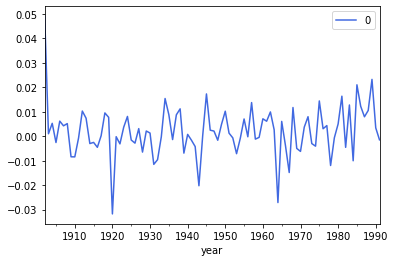

In [39]:
#Visualize resicudals
residuals = DataFrame(model213_fit.resid)
residuals.plot(color='royalblue')
plt.show()

In [40]:
#observe residuals/error distributions
residuals.describe()

,0
count,90.000000
mean,0.002000
std,0.010352
min,-0.031755
25%,-0.002969
50%,0.001266
75%,0.007612
max,0.049000


Based on the above, we observe that our model has minimal error with little bias, with a mean of approximately 0. Next, we observe a density plot of the residual error values, suggesting the errors ar gaussian, but may not be centered on zero

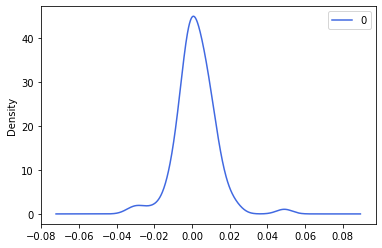

In [41]:
#check for linearlity
residuals = DataFrame(model213_fit.resid)
residuals.plot(kind='kde', color='royalblue')
plt.show()

Based on the above, we observe that our model is nearly linear, with mean of approximately 0. Next we observe the diagnostics to evaluate our model

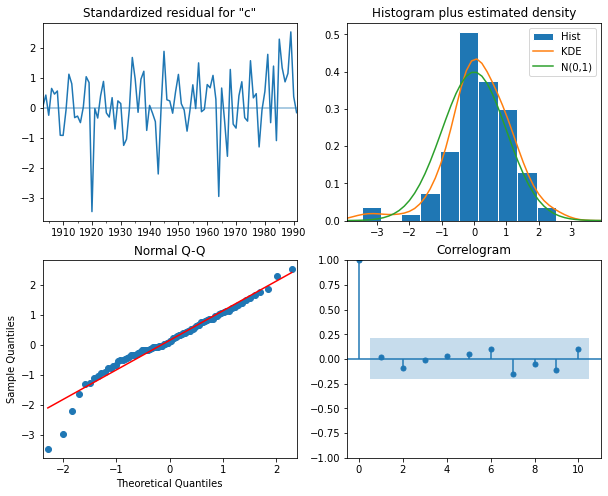

In [42]:
model213_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In the top right plot, thw orangered line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation 1. This is a good indication thath the residuals are normally distributed. The forecast errors deviate a little bit from the straight line, indicating that the normal distribution is not a perfect model for the distribution of forecast errors, but it is not unreasonable.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again,this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e, correlation) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

In [43]:
#observe predictions
pred_model213 = model213_fit.get_prediction(start='1990-01-01', end='2020-01-01', dynamic=False)
pred_ci = pred_model213.conf_int()
pred_ci.sample(10)

,lower co2_per_capita,upper co2_per_capita
2011-01-01,0.973714,1.536120
1991-01-01,0.674551,0.710432
1998-01-01,0.827256,0.983162
2008-01-01,0.950584,1.407793
2015-01-01,0.996423,1.706732
2004-01-01,0.910554,1.236812
2003-01-01,0.898688,1.194169
2020-01-01,1.013169,1.918403
2007-01-01,0.941584,1.364991
2010-01-01,0.966622,1.493366


we observe the real and forecasted values of the co2 emissions time series to assess how well the model fits.

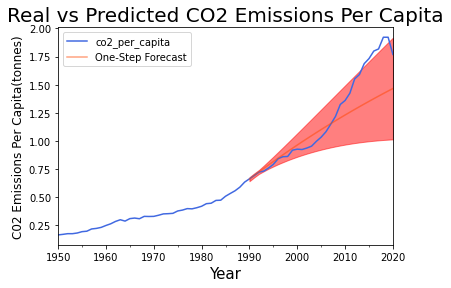

In [44]:
#observe real vs forecasted emissions values

#plot observed values
ax = df_India['1950-01-01':].plot(label='observed', color='royalblue')

#plot predicted values
pred_model213.predicted_mean.plot(ax=ax, label='One-Step Forecast', color='orangered', alpha=0.5)

#add fill between lines, set axes labels and title
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1],
               color='r', alpha=0.5)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita(tonnes)', size=12)
ax.set_title('Real vs Predicted CO2 Emissions Per Capita', size=20)

plt.legend()
plt.show()


Above we observe the forecast of per capita co2 emissions based on our fit model. 

The goal of developing the model is to get a good quality predictive power using dynamic forecast. That is, we use information from the timeseries up to a certain point, and after that point, forecasts are generated using values from historical time points 

In [45]:
#get dynamic predictions
pred_dynamic = model213_fit.get_prediction(start='1990-01-01', end='2020-01-01', dynamic=True, full_results=True)
#get confidence Intervals
pred_dynamic_ci = pred_dynamic.conf_int()


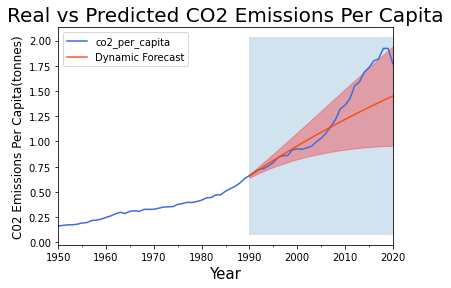

In [46]:
#plot observed values
ax = df_India['1950-01-01':].plot(label='observed', color='royalblue')

#plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orangered', alpha=0.9)

#add fill between lines, set axes labels and title
ax.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:, 0],
               pred_dynamic_ci.iloc[:, 1],
               color='r', alpha=0.3)

ax.fill_betweenx(ax.get_ylim(),
                '1990-01-01',
                df_India.index[-1],
                alpha=0.2,
                zorder= -1)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita(tonnes)', size=12)
ax.set_title('Real vs Predicted CO2 Emissions Per Capita', size=20)

plt.legend()
plt.show()


### Forecast Future CO2 emissions

**CO2 emissions Forecast for next 10 years by 2030**

In [48]:
#get forecast of 10 years stpes ahead in future
forecast2030 = model213_fit.get_forecast(steps=40)
#get confidence Intervals
forecast2030_ci = forecast2030.conf_int()
forecast2030_ci.tail(10)

,lower co2_per_capita,upper co2_per_capita
2022-01-01,1.016599,2.002408
2023-01-01,1.017662,2.044247
2024-01-01,1.018306,2.085973
2025-01-01,1.018540,2.127579
2026-01-01,1.018376,2.169064
2027-01-01,1.017823,2.210423
2028-01-01,1.016891,2.251654
2029-01-01,1.015588,2.292753
2030-01-01,1.013925,2.333717
2031-01-01,1.011909,2.374545


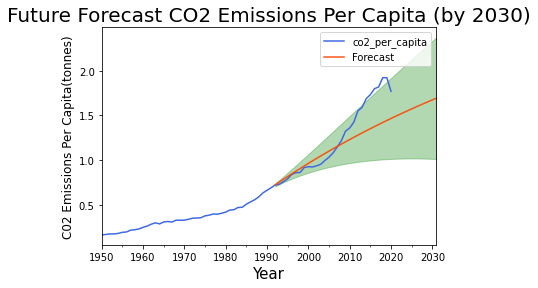

In [50]:

#plot observed values
ax = df_India['1950-01-01':].plot(label='observed', color='royalblue')

#plot predicted values
forecast2030.predicted_mean.plot(ax=ax, label='Forecast', color='orangered', alpha=0.9)

#add fill between lines, set axes labels and title
ax.fill_between(forecast2030_ci.index,
               forecast2030_ci.iloc[:, 0],
               forecast2030_ci.iloc[:, 1],
               color='g', alpha=0.3)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita(tonnes)', size=12)
ax.set_title('Future Forecast CO2 Emissions Per Capita (by 2030)', size=20)

plt.legend()
plt.show()

**CO2 emissions Forecast for next 20 years (by 2045)**

In [52]:
#get forecast of 10 years stpes ahead in future
forecast2045= model213_fit.get_forecast(steps=55)
#get confidence Intervals
forecast2045_ci = forecast2045.conf_int()
forecast2045_ci.sample(10)

,lower co2_per_capita,upper co2_per_capita
2023-01-01,1.017662,2.044247
2026-01-01,1.018376,2.169064
1996-01-01,0.791985,0.900416
2011-01-01,0.973714,1.536120
2016-01-01,1.000760,1.749234
2019-01-01,1.010778,1.876247
2017-01-01,1.004586,1.791655
1999-01-01,0.843204,1.024916
2027-01-01,1.017823,2.210423
2015-01-01,0.996423,1.706732


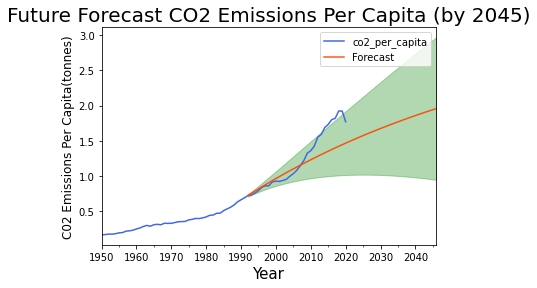

In [53]:
#plot observed values
ax = df_India['1950-01-01':].plot(label='observed', color='royalblue')

#plot predicted values
forecast2045.predicted_mean.plot(ax=ax, label='Forecast', color='orangered', alpha=0.9)

#add fill between lines, set axes labels and title
ax.fill_between(forecast2045_ci.index,
               forecast2045_ci.iloc[:, 0],
               forecast2045_ci.iloc[:, 1],
               color='g', alpha=0.3)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita(tonnes)', size=12)
ax.set_title('Future Forecast CO2 Emissions Per Capita (by 2045)', size=20)

plt.legend()
plt.show()

**CO2 emissions Forecast for next 50 years (by 2070)**

In [56]:
#get forecast of 10 years stpes ahead in future
forecast2070 = model213_fit.get_forecast(steps=80)
#get confidence Intervals
forecast2070_ci = forecast2070.conf_int()
forecast2070_ci.sample(10)

,lower co2_per_capita,upper co2_per_capita
2054-01-01,0.885084,3.272117
2020-01-01,1.013169,1.918403
2011-01-01,0.973714,1.536120
2018-01-01,1.007923,1.833997
2003-01-01,0.898688,1.194169
2066-01-01,0.772235,3.707128
2042-01-01,0.968738,2.814048
2022-01-01,1.016599,2.002408
2009-01-01,0.958903,1.450576
2039-01-01,0.984066,2.695987


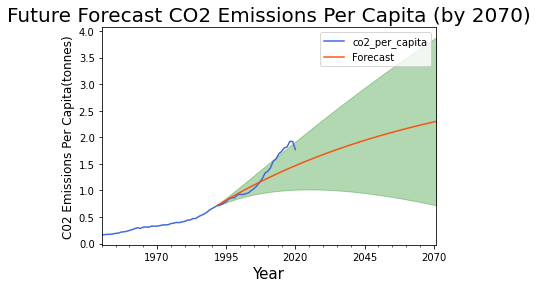

In [57]:
#plot observed values
ax = df_India['1950-01-01':].plot(label='observed', color='royalblue')

#plot predicted values
forecast2070.predicted_mean.plot(ax=ax, label='Forecast', color='orangered', alpha=0.9)

#add fill between lines, set axes labels and title
ax.fill_between(forecast2070_ci.index,
               forecast2070_ci.iloc[:, 0],
               forecast2070_ci.iloc[:, 1],
               color='g', alpha=0.3)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('C02 Emissions Per Capita(tonnes)', size=12)
ax.set_title('Future Forecast CO2 Emissions Per Capita (by 2070)', size=20)

plt.legend()
plt.show()

***Tasks***

> - _Adressing Trends and Stationarity - Differncing_
> - _Modelling_           (completed & yet to be reviewed | Add Explanation)
    - _ACF and PACF_
    - _AR, MA_
    - _ARIMA_
> - _Performance_
    - _RMSE_
    - _AIC_
> - _Analyse Final Model_



> - Build Neural Networks (ongoing)
    - GRU
    - LSTM
> - Performance and Analyse Neural Networks 